In [1]:
import requests # To make get calls to API
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup # Helps make parsing html files much easier
from functions import *
import pandas as pd
import spotipy
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
from tensorflow import keras 
from keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# This token was granted through the use of Genius's website and allows us to make calls to the API
client_access_token = "_mDTViAvedsTbhpMuhLml-2gkMw1DU8tKQRnqmFkQDXT2aypVvCg67wDEr4eqBIs"

Using TensorFlow backend.


In [ ]:
SPOTIPY_CLIENT_ID='19cb7472401c45c2acaa41ad01bb9e6d'
SPOTIPY_CLIENT_SECRET='7d3065a3086746f5bf7f94812e398230'

#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

# RapCaviar Playlist (Import Playlist Here)
# url = "https://open.spotify.com/playlist/37i9dQZF1DX0XUsuxWHRQd"

# Pop 2021
url = "https://open.spotify.com/playlist/02ES3fS2eHdLnDEuEUD60V"
artists = []
results = sp.playlist_items(url)
for idx, item in enumerate(results['items']):
    track = item['track']
    artists.append(track['artists'][0]['name'])
#     print(idx, track['artists'][0]['name'], " - ", track['name'])
result = [] 
[result.append(x) for x in artists if x not in result] 
print(result)


In [ ]:
all_songs = []
for artist_name in result:
    songs = request_song_url(artist_name, 10)
    lyrics = [""] * 10
    index = 0
    for song in songs:
        soup = BeautifulSoup(requests.get(song).content, 'lxml')
        lyrics[index] = ""

        for tag in soup.select('div[class^="Lyrics__Container"], .song_body-lyrics p'):

            for i in tag.select('i'):
                i.unwrap()
            tag.smooth()

            t = tag.get_text(strip=True, separator='\n')

            if t:
                lyrics[index]+=(t)
        print(index)
        index = index + 1
    search_term = artist_name
    genius_search_url = f"http://api.genius.com/search?q={search_term}&access_token={client_access_token}"
    response = requests.get(genius_search_url)
    json_data = response.json()
    for i in range(len(lyrics)):
        lyrics[i]= clean_lyrics(lyrics[i])
    print(lyrics[0])
    index = 0
    for song in json_data['response']['hits']:
        all_songs.append([search_term, song['result']['full_title'], lyrics[index]])
        index += 1

In [ ]:
# song = pd.DataFrame(all_songs)
# song.columns = ['artist_name', 'song_title', 'lyrics']
# compression_opts = dict(method='zip',
#                         archive_name='out.csv') 
# song.to_csv('out.zip', index=False,
#           compression=compression_opts)
song = pd.DataFrame(all_songs)
song.columns = ['artist_name', 'song_title', 'lyrics']
song.to_csv('pop.csv', index=False)

In [2]:
data = pd.read_csv ('pop.csv')
print("Artists in the data:\n",data.artist_name.value_counts()) 


Artists in the data:
 Billie Eilish          10
Marshmello             10
Katy Perry             10
Shawn Mendes           10
Troye Sivan            10
Jonas Brothers         10
Gryffin                10
Conan Gray             10
Laura Marano           10
Olivia Rodrigo         10
FLETCHER               10
Sabrina Carpenter      10
The Kid LAROI          10
Glass Animals          10
Kali Uchis             10
Swedish House Mafia    10
Dua Lipa               10
JESSIA                 10
Regard                 10
Post Malone            10
Harry Styles           10
NEIKED                 10
Ariana Grande          10
Doja Cat               10
Duncan Laurence        10
Taylor Swift           10
Ed Sheeran             10
Lady Gaga              10
BTS                    10
DJ Snake               10
Gia Woods              10
Surf Mesa              10
The Weeknd             10
Justin Bieber          10
Name: artist_name, dtype: int64


In [3]:
data["no_of_characters"] = data["lyrics"].apply(len)
data["no_of_words"]=data.apply(lambda row: nltk.word_tokenize(row["lyrics"]), axis=1).apply(len)
data["no_of_lines"] = data["lyrics"].str.split('\n').apply(len)
data.describe()

,no_of_characters,no_of_words,no_of_lines
count,340.000000,340.000000,340.000000
mean,1681.408824,402.650000,58.500000
std,546.415707,133.637882,16.458135
min,471.000000,119.000000,20.000000
25%,1339.250000,315.250000,46.750000
50%,1649.000000,384.500000,57.000000
75%,1982.500000,478.500000,68.000000
max,4784.000000,1091.000000,124.000000


<Figure size 1080x1080 with 0 Axes>

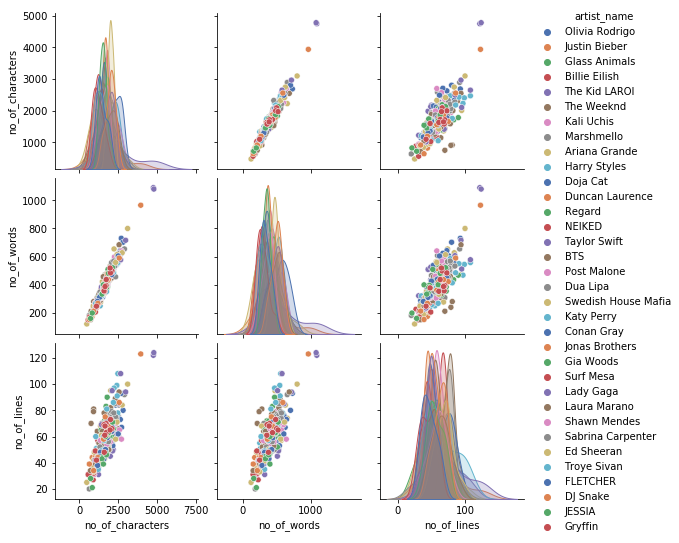

In [4]:
#Plotting the comparative song lengths for various artists
plt.figure(figsize=(15,15))
ax = sns.pairplot(data, hue="artist_name", palette="deep")


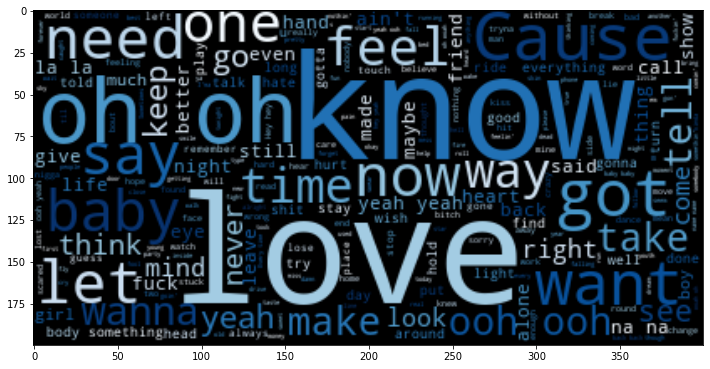

In [5]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#000000",colormap="Blues", max_words=800).generate(" ".join(data["lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [5]:
#Lining up all the lyrics to create corpus
Corpus =''
for listitem in data.lyrics:
    Corpus += listitem
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 470


In [6]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '!', '"', '&', "'", '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ú', 'ü', 'ı', 'œ', 'е', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '“', '”', '…', '\u205f', '中', '在', '站', '間', '가', '각', '간', '갈', '감', '강', '같', '개', '거', '걱', '건', '걸', '것', '게', '겐', '겔', '겠', '겨', '결', '계', '고', '곳', '공', '과', '관', '교', '구', '국', '굴', '그', '금', '기', '긴', '길', '김', '깊', '까', '깜', '깨', '꺾', '껄', '께', '꼴', '꽃', '꽤', '꾸', '꿈', '꿨', '끄', '끝', '끼', '끽', '낌', '나', '난', '날', '남', '났', '낯', '내', '낸', '냐', '너', '넌', '널', '넘', '네', '녀', '녁', '놀', '놓', '누', '눈', '는', '니', '다', '닥', '단', '달', '닮', '당', '닿', '대', '더', '던', '덜', '데', '도', '돌', '됐', '되', '될', '두', '둘', '둠', '득', '든', '듣', '들', '듭', '듯', '따', '때', '떠', '떤', '떨', '또', '뚜', '뛰', '뜬', '뜻', '라', '란', 

In [7]:
Corpus = re.sub("[^A-Za-z0-9'\.\n]"," ",Corpus)

In [8]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', "'", '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [9]:
print(Corpus)


i got my driver's license last week
just like we always talked about
'cause you were so excited for me
to finally drive up to your house
but today  i drove through the suburbs
crying 'cause you weren't around

and you're probably with that blonde girl
who always made me doubt
she's so much older than me
she's everything i'm insecure about
yeah  today  i drove through the suburbs
'cause how could i ever love someone else 

and i know we weren't perfect
but i've never felt this way for no one
and i just can't imagine
how you could be so okay now that i'm gone
guess you didn't mean what you wrote in that song about me
'cause you said forever  now i drive alone past your street

and all my friends are tired
of hearing how much i miss you  but
i kinda feel sorry for them
'cause they'll never know you the way that i do
yeah  today  i drove through the suburbs
and pictured i was driving home to you

and i know we weren't perfect
but i've never felt this way for no one  oh
and i just can't im

In [27]:
# Machine generated lyrics using Markov
import re
import random
from collections import defaultdict


class MarkovRachaita:
    def __init__(self, corpus='', order=2, length=8):
        self.order = order
        self.length = length
        self.words = re.findall("[a-z']+", corpus.lower())
        self.states = defaultdict(list)

        for i in range(len(self.words) - self.order):
            self.states[tuple(self.words[i:i + self.order])].append(self.words[i + order])

    def gen_sentence(self, length=8, startswith=None):
        terms = None
        if startswith:
            start_seed = [x for x in self.states.keys() if startswith in x]
            if start_seed:
                terms = list(start_seed[0])
        if terms is None:
            start_seed = random.randint(0, len(self.words) - self.order)
            terms = self.words[start_seed:start_seed + self.order]

        for _ in range(length):
            terms.append(random.choice(self.states[tuple(terms[-self.order:])]))

        return ' '.join(terms)

    def gen_song(self, lines=10, length=8, length_range=None, startswith=None):
        song = []
        if startswith:
            song.append(self.gen_sentence(length=length, startswith=startswith))
            lines -= 1
        for _ in range(lines):
            sent_len = random.randint(*length_range) if length_range else length
            song.append(self.gen_sentence(length=sent_len))
        return '\n'.join(song)

In [29]:
kanyai = MarkovRachaita(corpus=' '.join(data.lyrics))
kanyai.gen_song(lines=10, length_range=[5, 10])

"try try try try try try try try\nmy name you just having fun straight up now we'll never\nrest and boy i'll meet you downstairs at the space\naround i'm falling again i'm falling again i'm fallin'\nplease hold me come on come on now follow my lead come\na heart i won't hesitate just tell\nmore time oh babe you are know\nlove and control but you gotta be stressed just close your\nain't the same answer the phone today just to fit in\nall so if you don't wanna hear it"

In [32]:
kanyai.gen_song(lines=10, length_range=[5, 10], startswith='hello')

"bone hello welcome home don't you call out my hay\nthe rollercoaster's all i've ever had yeah it's when you touch\nknow you fucked her on grafton street right outside of an icky\nyou were on top of cars and downtown\nknow me you asked me for you\nleggo yo' aleluya y dejemo' que aqu\ngo slow no more we both were free but\ni'm in love with your body too tight yeah i'm\ni don't need to know ya packing\nyou in my life if you wanna cry i'll be your a"

In [11]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 571679
Number of unique characters: 40


In [12]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 571639


In [13]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
y = np_utils.to_categorical(targets)

In [14]:
def on_epoch_end(epoch, _):
    """Function invoked at end of each epoch. Prints generated text."""
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - seqlen - 1)
    
    # Q5: What does diversity do?
    for diversity in [0.2, 0.5, 1.0]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + seqlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, seqlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            
            # Q6: What is the dimensionality of `preds`? Why do we input `preds[0, -1]` to the `sample` function?
            preds = model.predict(x_pred, verbose=0)
            next_index = sample(preds[0, -1], diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [18]:
#Initialising the Model
model = Sequential()
adam = keras.optimizers.Adam(learning_rate=0.01)
#Adding layers
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(learning_rate=0.01), metrics=['accuracy'])
print(y.shape[1])
#Model's Summary               
model.summary()
from tensorflow.keras.callbacks import LambdaCallback


NameError: name 'max_seq_size' is not defined

In [16]:
#Training the Model
history = model.fit(X, y, batch_size=1681, epochs=1)

Epoch 1/10


ValueError: in user code:

    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\alexp\.conda\envs\DeepLearning_Env2\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 40) and (None, 40, 40) are incompatible


In [228]:
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        print(prediction)
        prediction = prediction.flatten()
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        print(index)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

In [229]:
#Generating a song from the model
song_1 = Lyrics_Generator("i need you to be with me while i am down", 400)
#Let's have a look at the song


[[2.37238832e-02 1.27590219e-03 5.01319785e-09 ... 5.09629796e-09
  5.29814895e-09 5.36063265e-09]
 [1.91955901e-02 5.80432435e-03 1.34526466e-09 ... 1.34838323e-09
  1.28404989e-09 1.44029664e-09]
 [2.45213800e-02 4.78509783e-04 3.00957634e-09 ... 2.98937845e-09
  2.98522461e-09 2.95923776e-09]
 ...
 [2.42705294e-02 7.29471843e-04 3.35374562e-14 ... 1.70801570e-14
  2.84469127e-14 2.84462079e-14]
 [2.42813506e-02 7.18650526e-04 3.63101651e-14 ... 1.88305324e-14
  3.12724954e-14 3.12068931e-14]
 [2.43015476e-02 6.98453957e-04 3.20148297e-14 ... 1.64578331e-14
  2.71195835e-14 2.71791306e-14]]
440


KeyError: 440

In [162]:
print(song_1)

i need you to be with me while i am down7777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777


In [ ]:
# model.save('429723.h5')

In [ ]:
import sys


# Q1: What is the purpose of this block? When is `char_indices` used? What about `indices_char`?
chars = sorted(list(set(Corpus)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Q2: What is the purpose of this block? What do the `seqlen` and `step` parameters do?
seqlen = 40
step = seqlen
sentences = []
for i in range(0, len(Corpus) - seqlen - 1, step):
    sentences.append(Corpus[i: i + seqlen + 1])

# Q3: What about this block? What is `x` and what is `y`? Why do they have this dimensionality?
x = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), seqlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    # Q3a: What happens in this loop?
    for t, (char_in, char_out) in enumerate(zip(sentence[:-1], sentence[1:])):
        x[i, t, char_indices[char_in]] = 1
        y[i, t, char_indices[char_out]] = 1


# Q4: Here we build the model. What does the `return_sequences` argument do? Why the dense layer at the end?
model = Sequential()
model.add(LSTM(128, input_shape=(seqlen, len(chars)), return_sequences=True))
model.add(Dense(len(chars), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['categorical_crossentropy', 'accuracy']
)

def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array."""
    preds = np.asarray(preds).astype('float64')
    preds = np.exp(np.log(preds) / temperature)  # softmax
    preds = preds / np.sum(preds)                #
    probas = np.random.multinomial(1, preds, 1)  # sample index
    return np.argmax(probas)                     #


def on_epoch_end(epoch, _):
    """Function invoked at end of each epoch. Prints generated text."""
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(Corpus) - seqlen - 1)
    
    # Q5: What does diversity do?
    for diversity in [0.2, 0.5, 1.0]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = Corpus[start_index: start_index + seqlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, seqlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            
            # Q6: What is the dimensionality of `preds`? Why do we input `preds[0, -1]` to the `sample` function?
            preds = model.predict(x_pred, verbose=0)
            next_index = sample(preds[0, -1], diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=1681,
          epochs=50,
          callbacks=[print_callback])

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.2679 - categorical_crossentropy: 3.2679 - accuracy: 0.1705
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " up  then you re down  and then between "
 up  then you re down  and then between                              e   e                        t        e    e        e       h   e     e e e                                            o                                                             o  o           o              e        o                      e                   o                                                t        o                                         o       
----- diversity: 0.5
----- Generating with seed: " up  then you re down  and then between "
 up  then you re down  and then between tet   ei  eee     l ea   t
e  e   t  oo nr kien iht   o  ia     y   n   a h m   ai i    t le 'e e e    o et'eea att  
oe  t er   y h    
  asht n o mi  e   e t  e tthe e n

i me me  oe  wo the the wyou  oh in a doon my anoano i wien whit it it a kut i  ind that you so and it  o  wot i'm oha cay it it all is ma bad at oh i'm soutou  oo and is  bea  oh you wan you you  i make i'm in you hee you  you moon ou an you sous ooh  ou  an the  fike the the you me bad no  i won't me you  i ming me the the tong  whe the you he wo  that 
i wan
----- diversity: 1.0
----- Generating with seed: "n i'm with my baby  yeah
all the bad thi"
n i'm with my baby  yeah
all the bad thing
aye ho  i hero owhyoom goy  ike

po wan'thand in  ion  seimy he tond i'm nha caok tas  ohoubire way und goo waig in ii   wat juto berwang  'mly hape coudari
goo wabe my sha witht came
if you hourman  mirtale you
maan ared it buneanda goou you hee toe
you cnp aramoue 
now midr ke i 
you  to  a kouge toe e doo buth
stin' baa lowe thereana  wave tha sao
waychiteolo doa fore moinorofmow louss

p  t
9/9 [==============================] - 45s 5s/step - loss: 2.1100 - categorical_crossentropy: 2.1100 - 

won't say your like me  i can't let me some to me  i'm some to me way you get me want you say  you can't let me don't want you want you  i don't wanna been the say  i want your been and i can't like your been the start me way  i can't get all a be a belling it want you  i can the say the way i wanna be the reme the prone in the way i want you  i can't live me  i want it's love it  i got your love me the
----- diversity: 0.5
----- Generating with seed: "if i can't have you here tonight

won't "
if i can't have you here tonight

won't well it's up and if i don't meen it all the cay then you got all read it  but i can't leve you  be tround on the manding it want it's hing a bed i'm shat i'm can i got what i don't me nover bettill is and me prought to make your bed it's still i  i feel like and i can't to get a like to got my hacling my hands it's for you  i don't let i don't make the way i storll me head this want your way oh  o
----- diversity: 1.0
----- Generating with seed: "if i can't